In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
# %%
# [第一步：修正此单元格]
%matplotlib inline
import numpy as np
from numpy import matrix
import matplotlib.pyplot as plt
import h5py
import inspect
import os
import pandas as pd

%load_ext autoreload
%autoreload 2

import path_utils
path_utils.add_path_to_sys_path("../../../code/python/lib", mode="relative_to_cwd", frame=inspect.currentframe())
import embree_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# %%
# [第二步：修正此单元格]
metadata_camera_parameters_csv_file = os.path.join("..", "metadata_camera_parameters.csv")

# 设定我们要分析的场景和图像
scene_name  = "ai_001_001"
camera_name = "cam_00"
frame_id    = 0

# 构建场景数据的根目录的正确路径
base_scene_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "examples", "01_marketplace_dataset", "scenes", scene_name))

# 使用新的 base_scene_dir 来构建所有数据路径
camera_dir = os.path.join(base_scene_dir, "_detail", camera_name)
img_dir    = os.path.join(base_scene_dir, "images")
mesh_dir   = os.path.join(base_scene_dir, "_detail", "mesh")

In [4]:
#
# read parameters from csv file
#

df_camera_parameters = pd.read_csv(metadata_camera_parameters_csv_file, index_col="scene_name")

df_ = df_camera_parameters.loc[scene_name]

width_pixels          = int(df_["settings_output_img_width"])
height_pixels         = int(df_["settings_output_img_height"])
meters_per_asset_unit = df_["settings_units_info_meters_scale"]

M_cam_from_uv = matrix([[ df_["M_cam_from_uv_00"], df_["M_cam_from_uv_01"], df_["M_cam_from_uv_02"] ],
                        [ df_["M_cam_from_uv_10"], df_["M_cam_from_uv_11"], df_["M_cam_from_uv_12"] ],
                        [ df_["M_cam_from_uv_20"], df_["M_cam_from_uv_21"], df_["M_cam_from_uv_22"] ]])

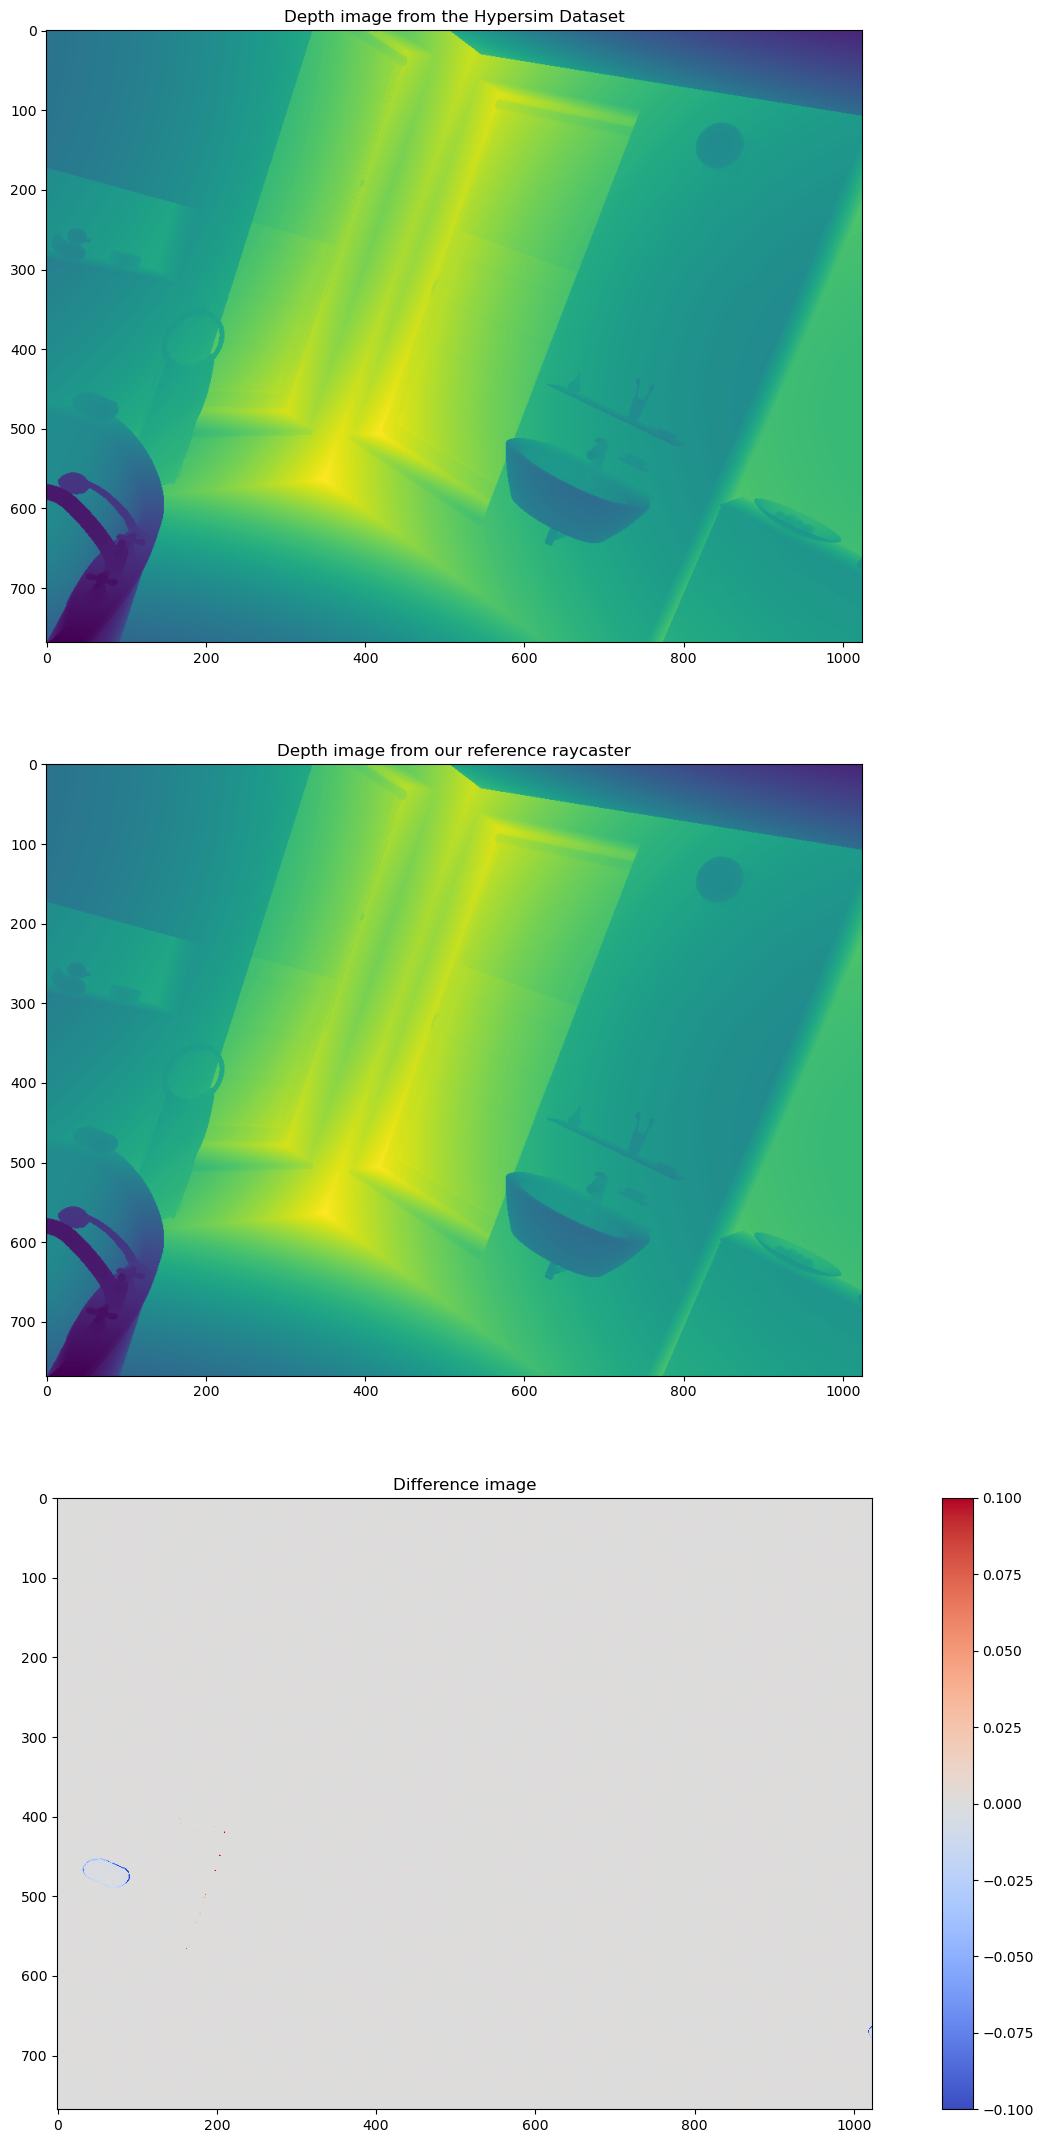

In [5]:
# %%\n",
# [第三步：完整修正此单元格]\n",

# --- [A. 数据加载部分] ---
# 在使用变量之前，从 HDF5 文件中加载它们

# 加载相机数据
camera_positions_hdf5_file    = os.path.join(camera_dir, "camera_keyframe_positions.hdf5")
camera_orientations_hdf5_file = os.path.join(camera_dir, "camera_keyframe_orientations.hdf5")
with h5py.File(camera_positions_hdf5_file,    "r") as f: camera_positions    = f["dataset"][:]
with h5py.File(camera_orientations_hdf5_file, "r") as f: camera_orientations = f["dataset"][:]

# 加载 Hypersim 官方深度图
hypersim_depth_meters_hdf5_file = os.path.join(img_dir, "scene_" + camera_name + "_geometry_hdf5", "frame.%04d.depth_meters.hdf5" % frame_id)
with h5py.File(hypersim_depth_meters_hdf5_file, "r") as f: hypersim_depth_meters = f["dataset"][:].astype(np.float32)

# 加载网格数据以用于光线投射
mesh_vertices_hdf5_file = os.path.join(mesh_dir, "mesh_vertices.hdf5")
mesh_faces_vi_hdf5_file = os.path.join(mesh_dir, "mesh_faces_vi.hdf5")
with h5py.File(mesh_vertices_hdf5_file, "r") as f: mesh_vertices = f["dataset"][:]
with h5py.File(mesh_faces_vi_hdf5_file, "r") as f: mesh_faces_vi = f["dataset"][:]
    
# --- [B. 原始计算与绘图部分] ---
# get position and rotation matrix for Hypersim image
camera_position_world = camera_positions[frame_id]
R_world_from_cam      = camera_orientations[frame_id]

# create grid of uv-values
u_min  = -1.0
u_max  = 1.0
v_min  = -1.0
v_max  = 1.0
half_du = 0.5 * (u_max - u_min) / width_pixels
half_dv = 0.5 * (v_max - v_min) / height_pixels

u, v = np.meshgrid(np.linspace(u_min+half_du, u_max-half_du, width_pixels),
                np.linspace(v_min+half_dv, v_max-half_dv, height_pixels)[::-1])

uvs_2d = np.dstack((u,v,np.ones_like(u)))
P_uv   = np.matrix(uvs_2d.reshape(-1,3)).T

# compute our own rays
P_cam_rays            = M_cam_from_uv * P_uv
ray_directions_world  = (R_world_from_cam * P_cam_rays).T.A
ray_positions_world   = np.ones_like(ray_directions_world) * camera_position_world

# get intersection distances using our own reference raycaster,
# reshape into 2D image, scale to meters
intersection_distances, intersection_normals, prim_ids = \
    embree_utils.generate_ray_intersections(mesh_vertices, mesh_faces_vi, ray_positions_world, ray_directions_world, tmp_dir="_tmp")

intersection_distances_2d = intersection_distances.reshape(height_pixels, width_pixels) * meters_per_asset_unit
difference                = hypersim_depth_meters - intersection_distances_2d

plt.figure(figsize=(18,27))

plt.subplot(311); plt.imshow(hypersim_depth_meters);     plt.title("Depth image from the Hypersim Dataset");
plt.subplot(312); plt.imshow(intersection_distances_2d); plt.title("Depth image from our reference raycaster");
plt.subplot(313); plt.imshow(difference, cmap='coolwarm', vmin=-0.1, vmax=0.1); plt.colorbar(); plt.title("Difference image");